# 01.01 EDA y Modelo Inicial
Este programa muestra como cargar un archivo, hacer un mínimo tratamiento y exploración de datos. Plantea algunas reglas de clasificación básica y evalúa los resultados.

In [1]:
#Se limpia la memoria
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,610213,32.6,1319164,70.5,1083714,57.9
Vcells,1138618,8.7,8388608,64.0,1821099,13.9


In [2]:
#La librería data table permite manejar grandes volumenes de datos en memoria
library("data.table")

#Contiene funciones para evaluar performance de la clasificación
library("ROCR")

#Permite generar graficos y visualizaciones
library(ggplot2)

In [3]:
setwd("~/cloudL/UA/labo2022/")


#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "./datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "competencia1_2022.csv")

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "01-EDA"

#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000


## Lectura y manejo básico de datos

In [4]:
#Lectura de archivo de en un data frame
dataset <- fread(karchivo_entrada)

### Estadísticas básicas del dataset

In [5]:
summary(dataset[,1:10]) #Primeras 10 columnas

 numero_de_cliente      foto_mes      active_quarter    cliente_vip      
 Min.   : 31115668   Min.   :202101   Min.   :0.0000   Min.   :0.000000  
 1st Qu.: 67385377   1st Qu.:202101   1st Qu.:1.0000   1st Qu.:0.000000  
 Median : 96202094   Median :202103   Median :1.0000   Median :0.000000  
 Mean   :101298735   Mean   :202102   Mean   :0.9849   Mean   :0.002791  
 3rd Qu.:132200932   3rd Qu.:202103   3rd Qu.:1.0000   3rd Qu.:0.000000  
 Max.   :212524211   Max.   :202103   Max.   :1.0000   Max.   :1.000000  
    internet        cliente_edad    cliente_antiguedad mrentabilidad      
 Min.   :0.00000   Min.   : 18.00   Min.   :  1.0      Min.   :-196977.8  
 1st Qu.:0.00000   1st Qu.: 37.00   1st Qu.: 61.0      1st Qu.:    -48.8  
 Median :0.00000   Median : 45.00   Median :126.0      Median :   1165.5  
 Mean   :0.04393   Mean   : 46.83   Mean   :133.3      Mean   :   2429.5  
 3rd Qu.:0.00000   3rd Qu.: 56.00   3rd Qu.:188.0      3rd Qu.:   3094.1  
 Max.   :4.00000   Max.   :101.0

In [6]:
#El universo agrupado por  clase_ternaria
ftable(dataset$clase_ternaria)

        BAJA+1 BAJA+2 CONTINUA
                              
 162900    664    850   159828

In [7]:
ftable(dataset[,c('foto_mes','clase_ternaria')])

         clase_ternaria        BAJA+1 BAJA+2 CONTINUA
foto_mes                                             
202101                       0    664    850   159828
202103                  162900      0      0        0

In [8]:
dtrain = dataset[ foto_mes==202101]
dapply = dataset[ foto_mes==202103]



# Selección de datos
Los data frames pueden filtrarse especificando entre corchetes las filas y columnas [filas,columnas]. Las formas de especificar mas usadas son:
- Índice numérico, por ejemplo, *1:10* indica del elemento 1 al 10 (inclusive)
- Nombre o lista de nombres, por ejemplo, *campo*
- Lista de valores Verdadero/Falso. Es utilizadon con condiciones del tipo *columna == valor*


In [9]:
#Seleccionar 3 primeras filas y campos indicados. La función c() genera una lista de valores
dtrain[1:3,c("Master_mconsumototal","clase_ternaria")]

Master_mconsumototal,clase_ternaria
<dbl>,<chr>
NA,CONTINUA
NA,CONTINUA
9149.4,CONTINUA


In [10]:
dtrain[1:5,c(1:5,155)]

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,clase_ternaria
<int>,<int>,<int>,<int>,<int>,<chr>
31115668,202101,1,0,0,CONTINUA
31115678,202101,1,0,0,CONTINUA
31117415,202101,1,0,0,CONTINUA
31117711,202101,1,0,0,CONTINUA
31118145,202101,1,0,0,CONTINUA


In [11]:
#Seleccion por un campo indirecto. kclase_nomcampo es una variable que tiene el nombre del campo. 
dtrain[1:3,..kclase_nomcampo]

clase_ternaria
<chr>
CONTINUA
CONTINUA
CONTINUA


Para seleccionar en base a una condicion se arma una lista con Verdadero/Falso actuando como flitro de línea. La siguiente lista adopata el valor Verdadero para las líneas BAJA+2

In [12]:
c(dtrain[,..kclase_nomcampo] == kclase_valor_positivo)

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [157] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [241] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [253]  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [301] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [313] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [349] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [397] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [409] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [433] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [469] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [481] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [493] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [505] FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE
  [517] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [529] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [541] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [553] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [565] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [577] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [589] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [6

Pasando el filtro como condición de línea al data frame se pueden seleccionar solo las que cumplen con la condición

In [13]:
dtrain[c(dtrain[,..kclase_nomcampo] == kclase_valor_positivo),][1:10]

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,⋯,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,clase_ternaria
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>
31282207,202101,0,0,0,44,292,-2313.80,-3919.05,1225.04,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,BAJA+2
31449517,202101,1,0,0,71,262,1248.52,17804.40,1823.18,⋯,11,1777.09,-2250.51,0.00,5673,1759.50,1,0,82.11,BAJA+2
31750204,202101,1,0,0,61,199,10509.30,20954.08,13584.13,⋯,11,44490.43,-64936.36,0.00,6025,61346.66,31,0,5266.77,BAJA+2
31763893,202101,1,0,0,55,77,-1746.74,12032.38,60.09,⋯,25,0.00,-4498.30,0.00,2327,17958.63,2,0,0.00,BAJA+2
31995750,202101,1,0,1,54,320,987.59,10883.84,192.97,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,BAJA+2
32285650,202101,1,0,0,51,119,-99.44,10927.69,0.00,⋯,11,0.00,NA,NA,2174,NA,NA,NA,0.00,BAJA+2
32375335,202101,1,0,0,81,320,-411.87,5546.97,998.03,⋯,4,0.00,-67729.79,0.00,9999,11373.75,6,0,1771.23,BAJA+2
32645693,202101,0,0,1,76,320,453.42,3084.30,0.00,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,BAJA+2
32709717,202101,1,0,0,78,320,5188.76,73467.32,1225.04,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,BAJA+2


### Modificación de datos

Puedo asignar valores a una columna del data frame con el operador := En este caso la referencia indirecta debe hacerse entre paréntesis

In [14]:
#Creo una columna con valor constante
dtrain[,(kobjetivo) := 0]
#dtrain[  , clase:= 0 ]   Es lo mismo! kobjetivo se definio igual al string "clase"

Asigno 1 en caso de BAJA+2 y 0 para cualquier otro valor.

In [15]:
#clase
dtrain[ clase_ternaria=='BAJA+2' ,   clase:= 1]
sum( dtrain$clase )

[1] 850

Puedo eliminar columnas asignandoles el valor NULL

In [16]:
#Borro una o varias columnas
#dtrain[ ,  (kcampos_a_borrar) := NULL    ] 

In [17]:
#calculo la ganancia de incentivar cada caso
dtrain[  , ganancia:= kFPGain ] #-1250
dtrain[ clase_ternaria=='BAJA+2' ,   ganancia:= kTPGain] #48750
sum( dtrain$ganancia )

[1] -159177500

Puedo asignar valores a un dtrain "filtrado". En este caso imputo 0 en los NA

In [18]:
#Puedo asignar valores a cualquier campo que cumpla con una condici. Ejemplo valores NA
dtrain[is.na(dtrain)] <- 0

# Resumen básico del dtrain
summary( dtrain)

 numero_de_cliente      foto_mes      active_quarter    cliente_vip      
 Min.   : 31115668   Min.   :202101   Min.   :0.0000   Min.   :0.000000  
 1st Qu.: 67277362   1st Qu.:202101   1st Qu.:1.0000   1st Qu.:0.000000  
 Median : 95958621   Median :202101   Median :1.0000   Median :0.000000  
 Mean   :100998246   Mean   :202101   Mean   :0.9841   Mean   :0.002987  
 3rd Qu.:131861321   3rd Qu.:202101   3rd Qu.:1.0000   3rd Qu.:0.000000  
 Max.   :211528586   Max.   :202101   Max.   :1.0000   Max.   :1.000000  
    internet        cliente_edad    cliente_antiguedad mrentabilidad      
 Min.   :0.00000   Min.   : 18.00   Min.   :  1.0      Min.   :-196977.8  
 1st Qu.:0.00000   1st Qu.: 37.00   1st Qu.: 61.0      1st Qu.:    -59.4  
 Median :0.00000   Median : 45.00   Median :126.0      Median :   1089.0  
 Mean   :0.03539   Mean   : 46.82   Mean   :132.9      Mean   :   2409.5  
 3rd Qu.:0.00000   3rd Qu.: 56.00   3rd Qu.:187.0      3rd Qu.:   2919.1  
 Max.   :4.00000   Max.   :101.0

In [19]:
#Resumen segregado por clase ternaria
by(dtrain, dtrain$clase_ternaria, summary)

dtrain$clase_ternaria: BAJA+1
 numero_de_cliente      foto_mes      active_quarter    cliente_vip
 Min.   : 31127916   Min.   :202101   Min.   :0.0000   Min.   :0   
 1st Qu.: 75534046   1st Qu.:202101   1st Qu.:1.0000   1st Qu.:0   
 Median :107183480   Median :202101   Median :1.0000   Median :0   
 Mean   :108286299   Mean   :202101   Mean   :0.8223   Mean   :0   
 3rd Qu.:142260228   3rd Qu.:202101   3rd Qu.:1.0000   3rd Qu.:0   
 Max.   :207072528   Max.   :202101   Max.   :1.0000   Max.   :0   
    internet       cliente_edad   cliente_antiguedad mrentabilidad      
 Min.   :0.0000   Min.   :23.00   Min.   :  2.0      Min.   :-25374.53  
 1st Qu.:0.0000   1st Qu.:37.75   1st Qu.: 40.0      1st Qu.:    98.32  
 Median :0.0000   Median :48.00   Median : 84.0      Median :  1289.51  
 Mean   :0.1054   Mean   :49.12   Mean   :109.0      Mean   :  1556.02  
 3rd Qu.:0.0000   3rd Qu.:60.00   3rd Qu.:161.2      3rd Qu.:  1869.76  
 Max.   :2.0000   Max.   :88.00   Max.   :373.0      Max

## EDA


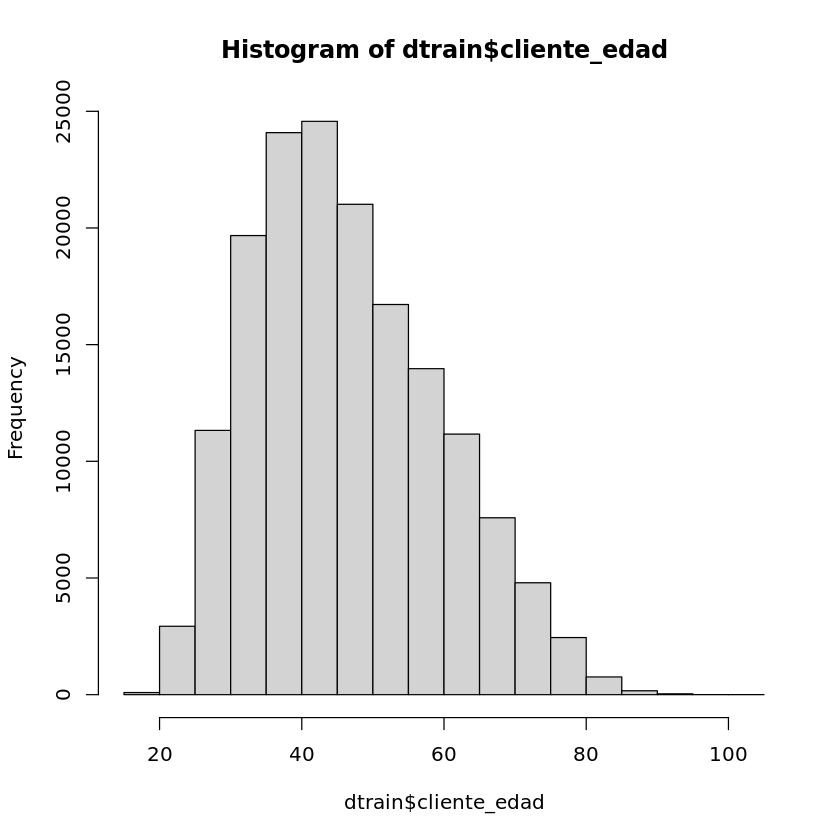

In [20]:
hist(dtrain$cliente_edad)

In [21]:
#Se comportan diferente?
ftable(dtrain[ cliente_edad <=33, clase])

     0     1
            
 25281   123

In [22]:
ftable(dtrain[ cliente_edad  >33, clase])

      0      1
              
 135211    727

In [23]:
#Ganancia
sum( dtrain[ cliente_edad <=33, ganancia] )

[1] -25605000

In [24]:
#Lift
(sum( dtrain[ cliente_edad <=33, clase]) / nrow( dtrain[ cliente_edad <=33, ] )) /  (sum( dtrain[, clase]) / nrow( dtrain ))

[1] 0.9190339

In [25]:
#Ganancia
sum( dtrain[ cliente_edad >33, ganancia] )


[1] -133572500

In [26]:
#Lift
(sum( dtrain[ cliente_edad >33, clase]) / nrow( dtrain[ cliente_edad >33, ] )) /  (sum( dtrain[, clase]) / nrow( dtrain ))

[1] 1.015131

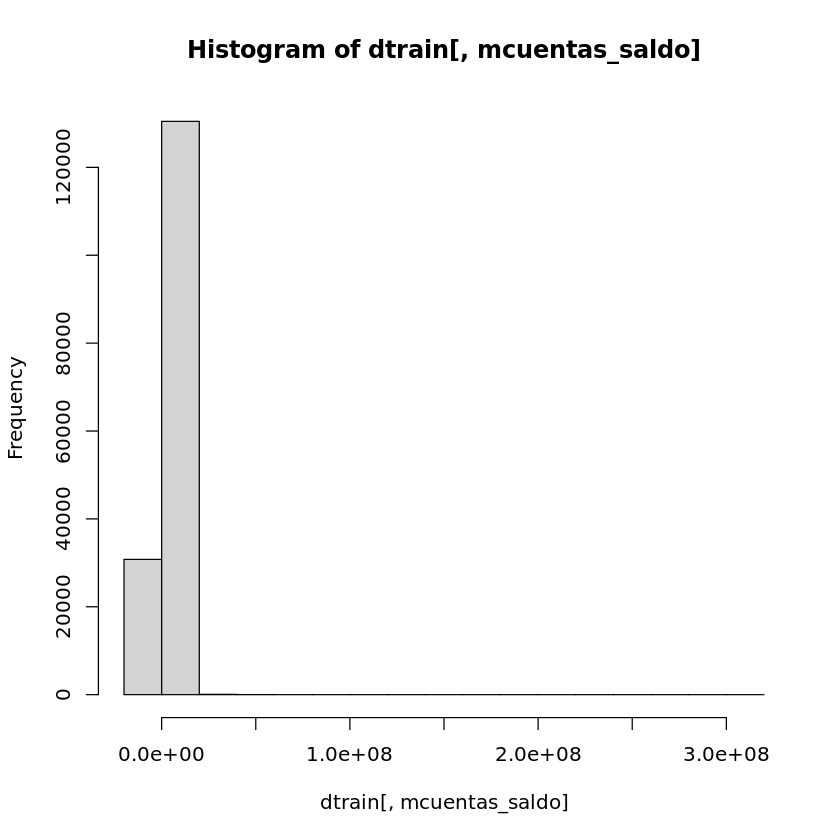

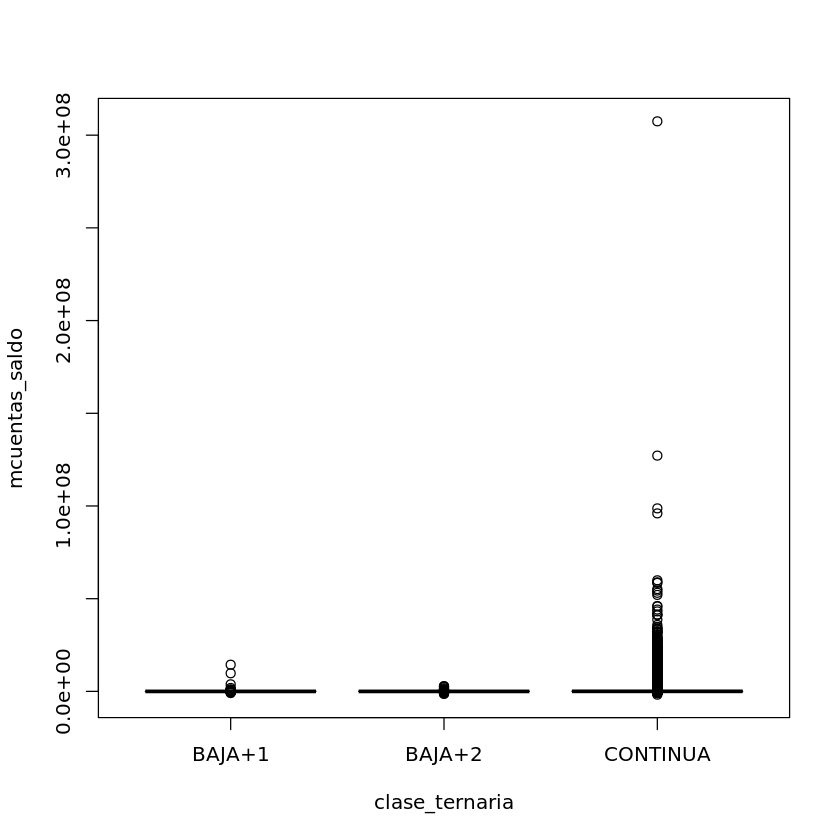

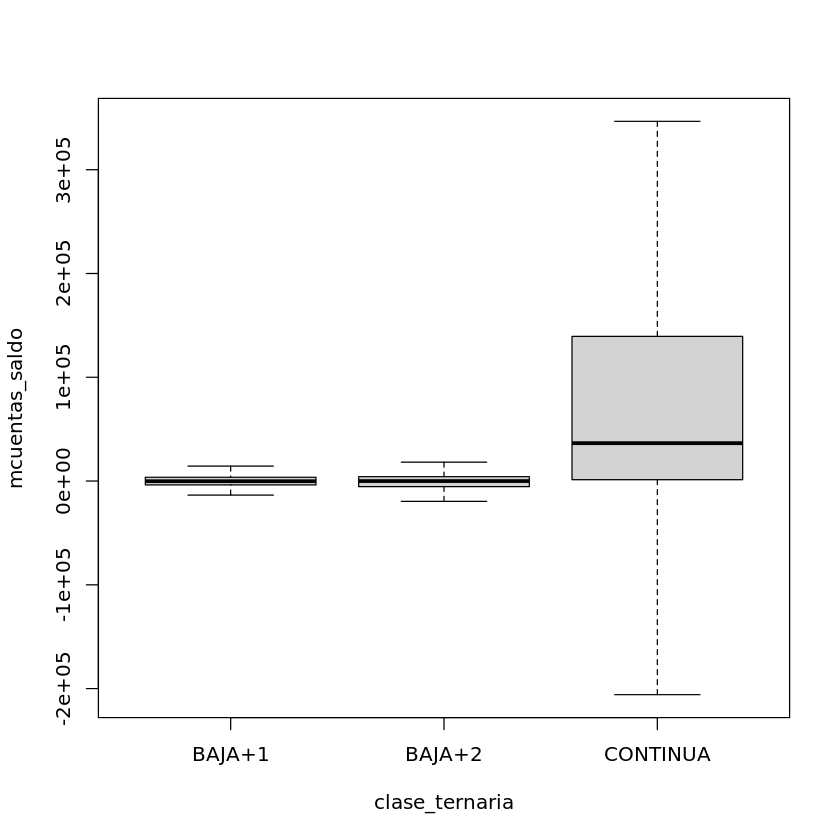

In [27]:
#Corte por mcuentas_saldo
hist(dtrain[ ,mcuentas_saldo] )
boxplot(mcuentas_saldo  ~ clase_ternaria, data=dtrain)
boxplot(mcuentas_saldo  ~ clase_ternaria, data=dtrain, outline=FALSE)

In [28]:
ftable(dtrain[ mcuentas_saldo <= -120000, clase_ternaria])

 BAJA+1 BAJA+2 CONTINUA
                       
      5      6      142

In [29]:
ftable(dtrain[ mcuentas_saldo >  -120000, clase_ternaria])

 BAJA+1 BAJA+2 CONTINUA
                       
    659    844   159686

In [30]:
sum( dtrain[ mcuentas_saldo <= -120000, ganancia] )

[1] 108750

In [31]:
sum( dtrain[ mcuentas_saldo > -120000, ganancia] )

[1] -159286250

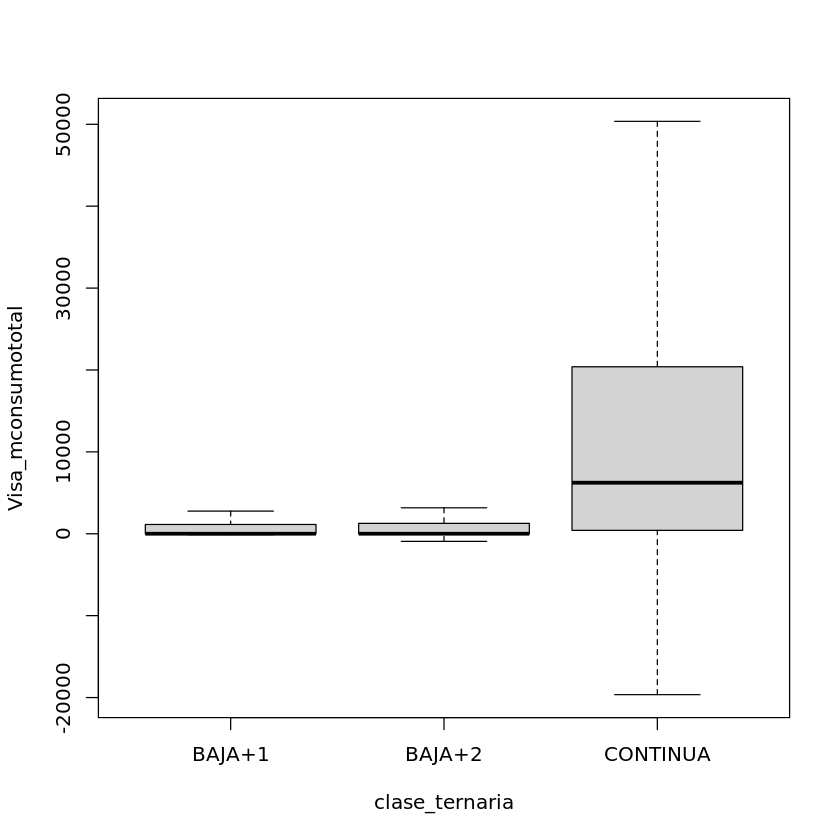

In [32]:
boxplot(Visa_mconsumototal  ~ clase_ternaria, data=dtrain, outline=FALSE)

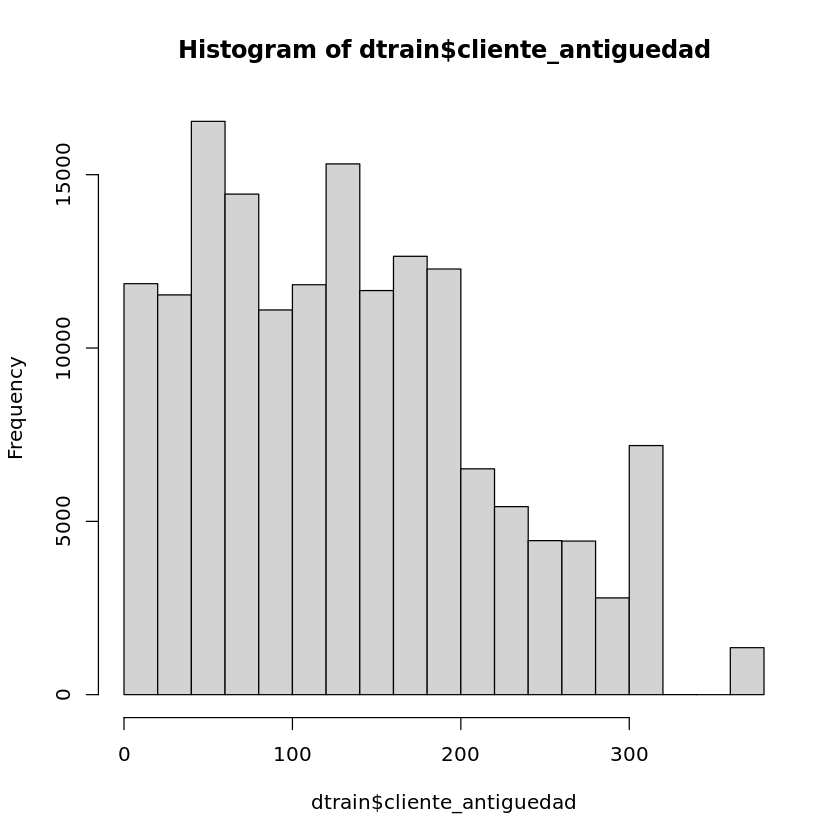

In [33]:
hist(dtrain$cliente_antiguedad)

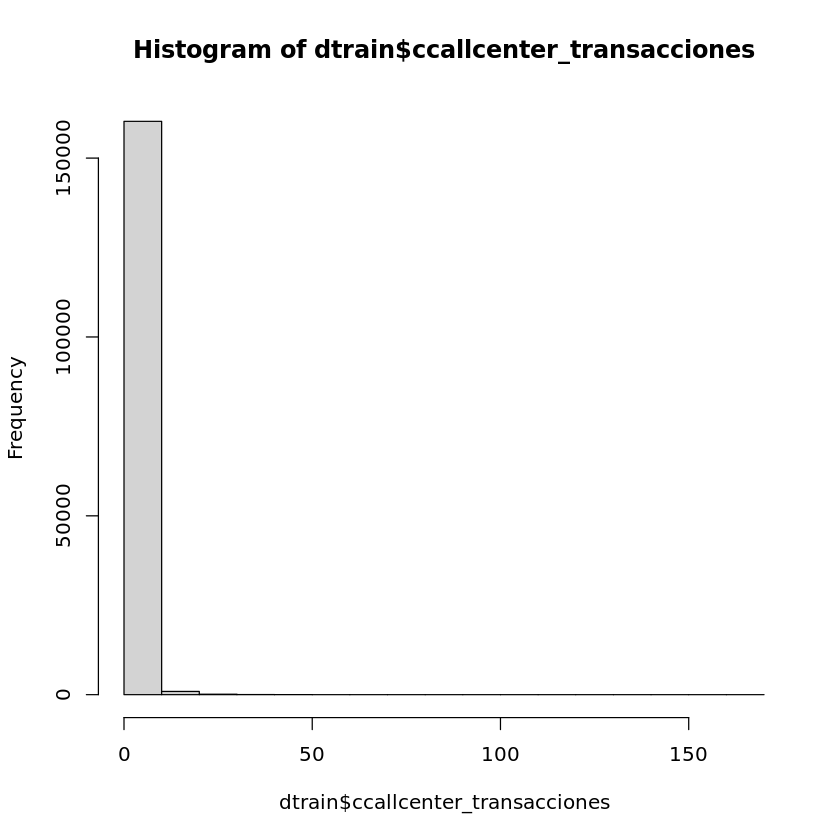

In [34]:
hist(dtrain$ccallcenter_transacciones)

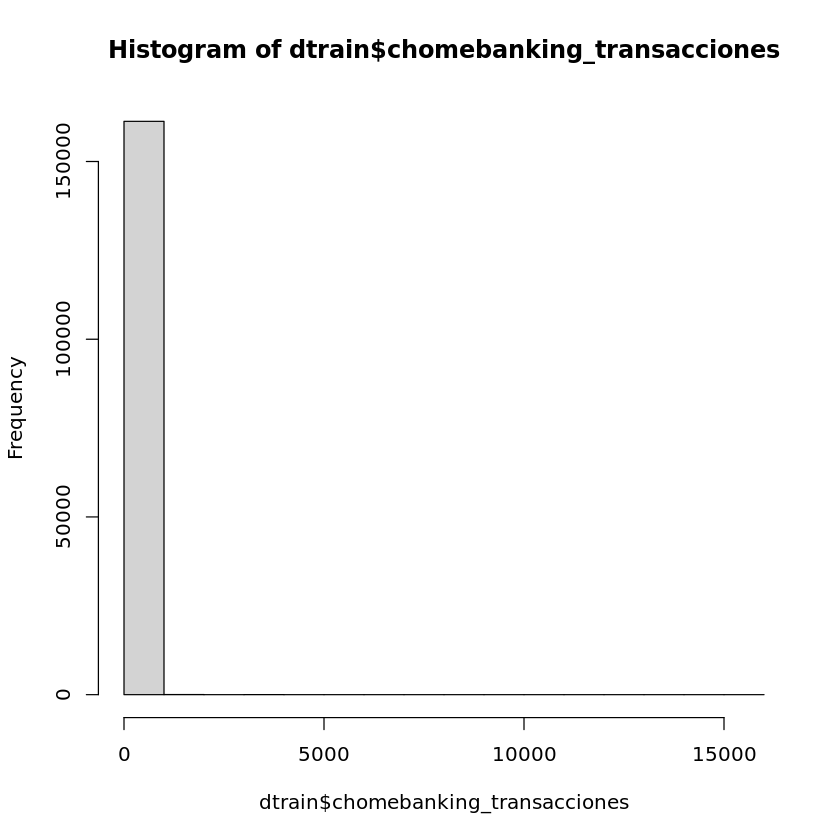

In [35]:
hist(dtrain$chomebanking_transacciones)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


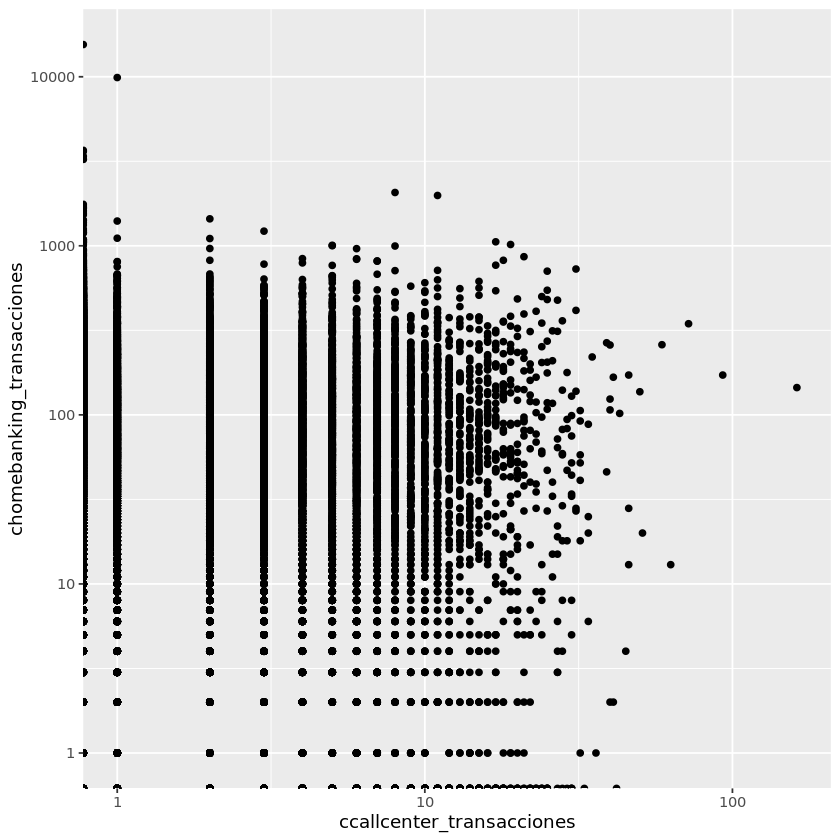

In [36]:
ggplot(dtrain, aes(x=ccallcenter_transacciones, y=chomebanking_transacciones)) + # fill=name allow to automatically dedicate a color for each group
        geom_point()+
        scale_x_log10()+
        scale_y_log10()


Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 37534 rows containing non-finite values (stat_bin).”


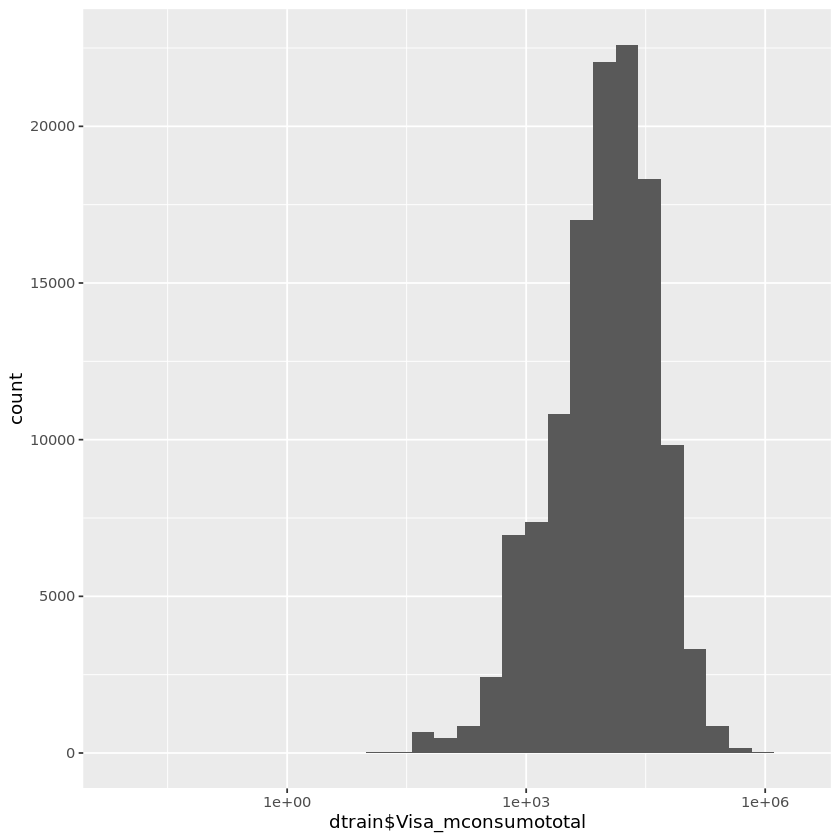

In [37]:
ggplot(dtrain, aes(x=dtrain$Visa_mconsumototal))+ geom_histogram() + scale_x_log10()

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 117853 rows containing non-finite values (stat_bin).”


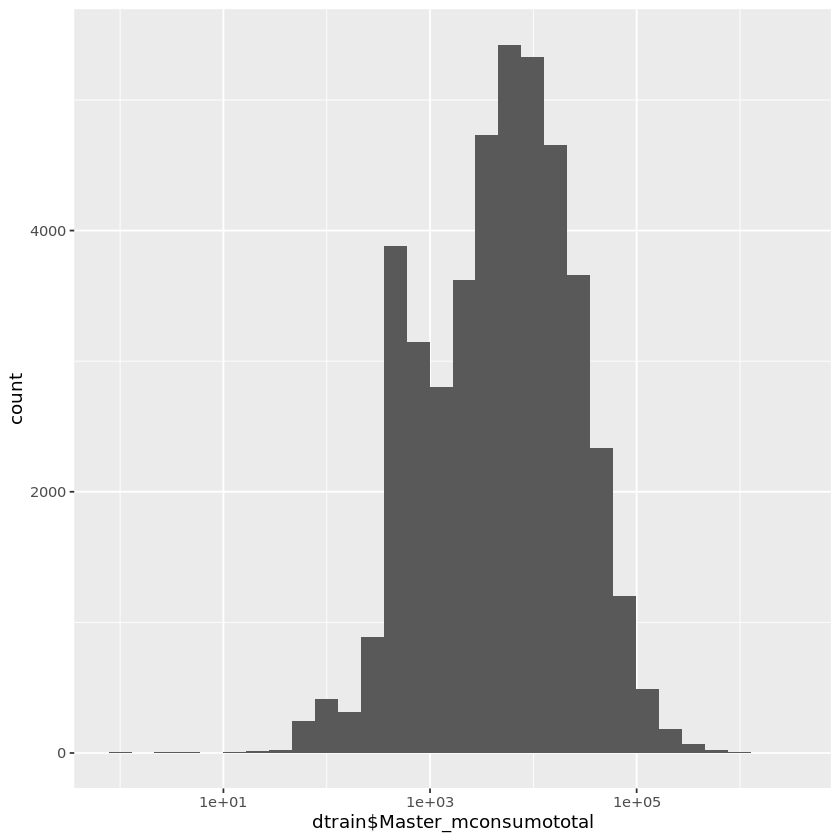

In [38]:
ggplot(dtrain, aes(x=dtrain$Master_mconsumototal))+ geom_histogram() + scale_x_log10()

Determino correlaciones entre las variables y el objetivo. 

In [39]:
dtrain[ ,  (kcampos_a_borrar) := NULL    ] 
correlaciones <- abs(cor(dtrain[,-..kobjetivo],dtrain[,..kobjetivo]))

In [40]:
correlaciones[order(-correlaciones[,1]),][0:20]

ganancia                    active_quarter 
                       1.00000000                        0.12140915 
                    ctarjeta_visa                      ctrx_quarter 
                       0.07721011                        0.07245627 
                       cproductos                   ctarjeta_master 
                       0.06160631                        0.05757142 
         cdescubierto_preacordado                   cmobile_app_trx 
                       0.05733004                        0.05242530 
                ccomisiones_otras       ctarjeta_visa_transacciones 
                       0.04931127                        0.04818753 
    ctarjeta_debito_transacciones                      thomebanking 
                       0.04669670                        0.04288702 
                     cpayroll_trx                     mautoservicio 
                       0.04257854                        0.04124260 
                   Visa_cconsumos             mtarjeta_visa_consumo 
                       0.04031856                        0.03822482 
                      Visa_status         ccomisiones_mantenimiento 
                       0.03815271                        0.03714049 
ctarjeta_visa_debitos_automaticos                   cpagomiscuentas 
                       0.03640045                        0.03551144

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 8053 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 8053 rows containing non-finite values (stat_ydensity).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1949 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1949 rows containing non-finite values (stat_ydensity).”


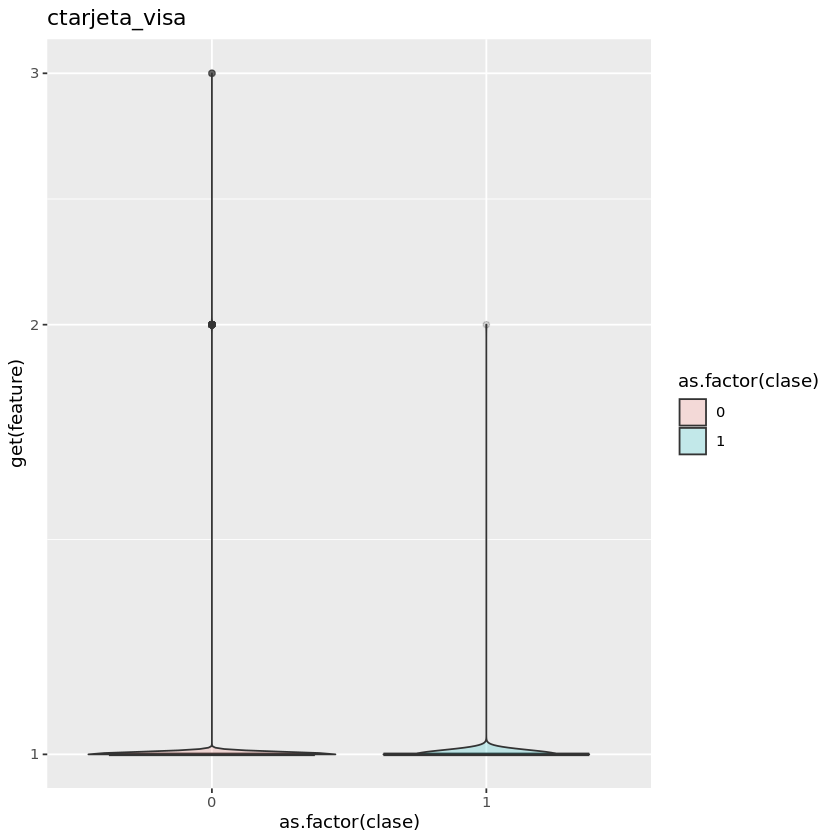

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 17250 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 17250 rows containing non-finite values (stat_ydensity).”


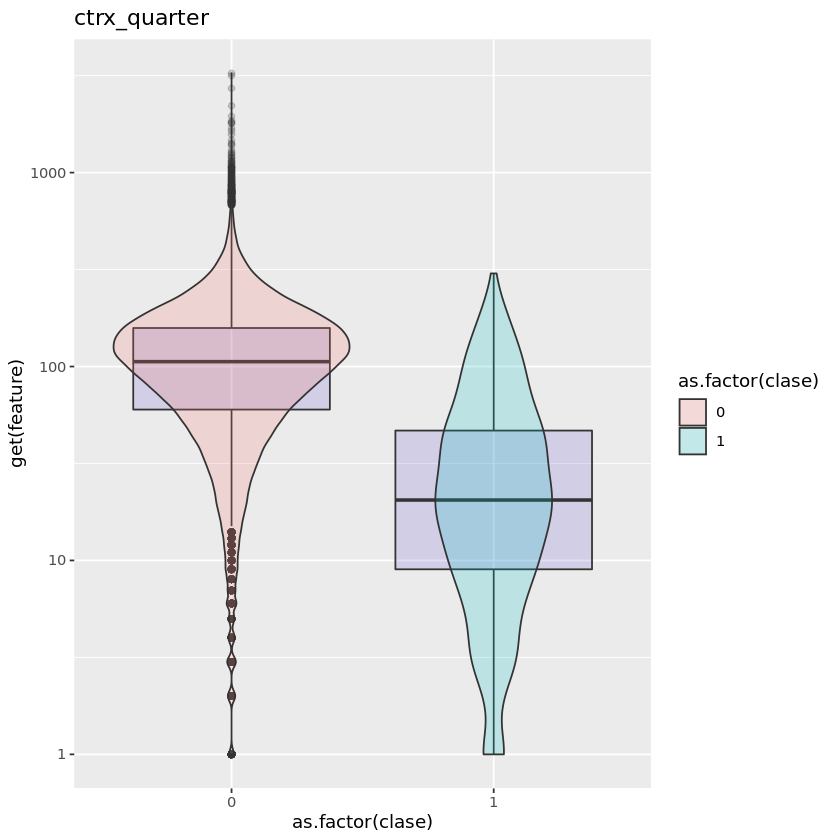

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 48759 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 48759 rows containing non-finite values (stat_ydensity).”


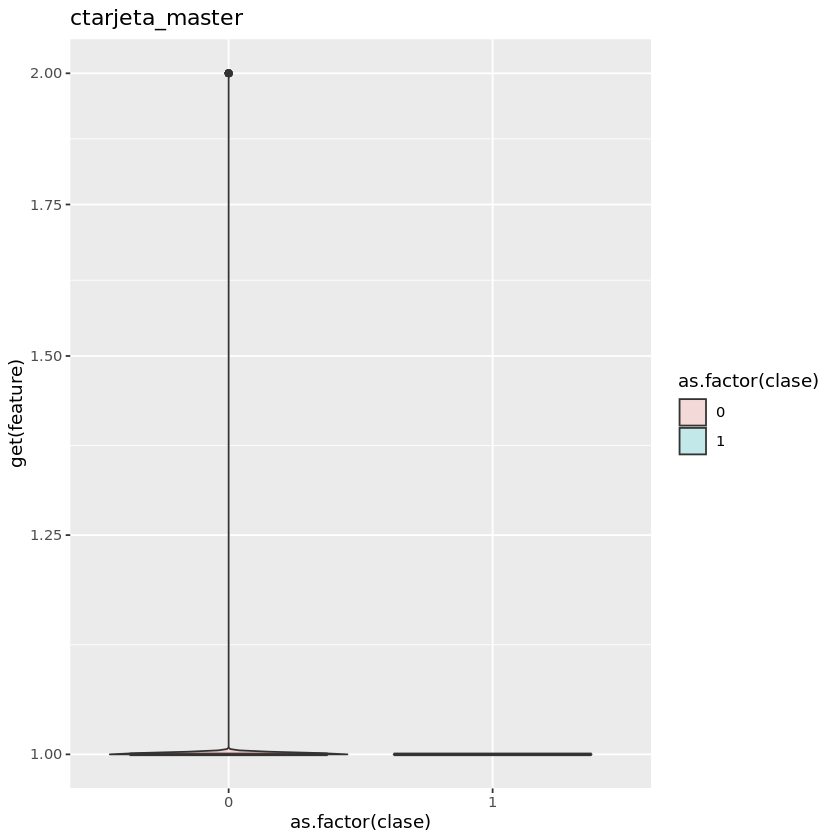

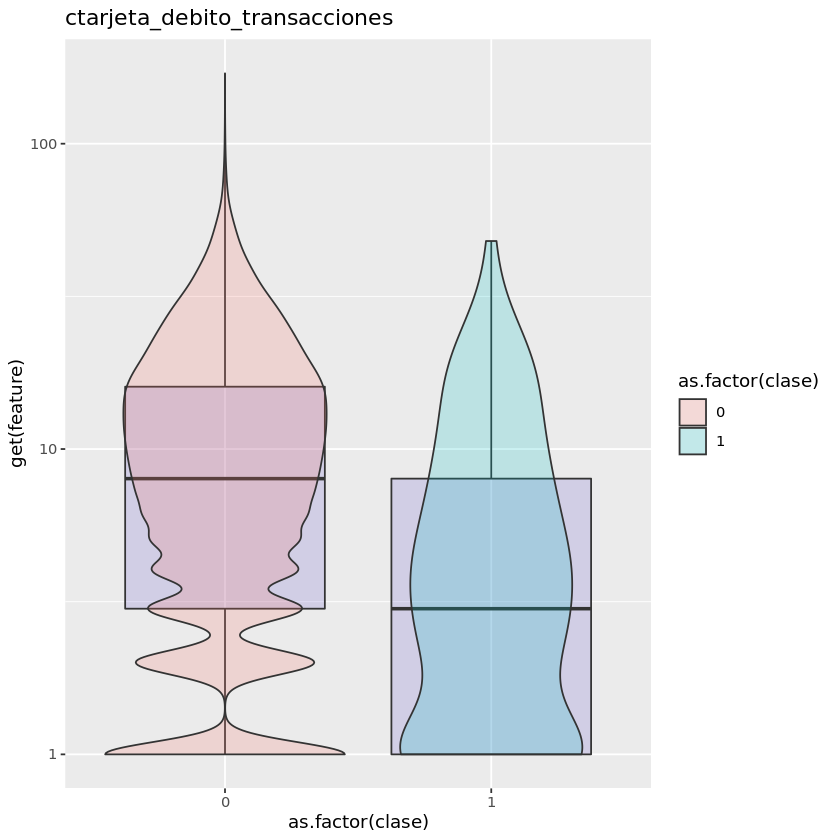

In [41]:
library(ggplot2)

for (feature in names(correlaciones[order(-correlaciones[,1]),][c(3,4,6,11)])) {
    
    
    plot <- ggplot(dtrain, aes(x=as.factor(clase), y=get(feature), fill=as.factor(clase))) + # fill=name allow to automatically dedicate a color for each group
      geom_boxplot(fill="slateblue", alpha=0.2)+
      geom_violin(alpha=0.2)+
    ggtitle(feature)+
        scale_y_log10()
    print(plot)
    
}

## Modelo básico
Vamos a definir un modelo muy básico. La gente que no usa las tarjetas de crédito es candidata a darse de baja. Defino una variable como la suma de transacciones en ambas franquicias.

Warning message:
“Removed 25192 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 25192 rows containing non-finite values (stat_ydensity).”


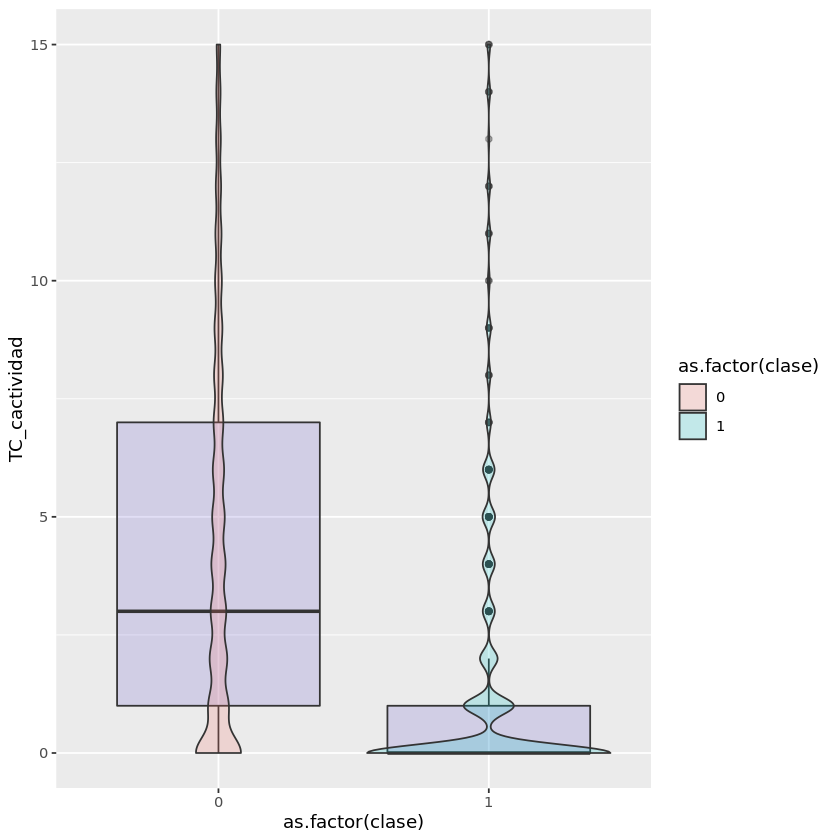

In [42]:
dtrain$TC_cactividad = dtrain$Visa_cconsumos + dtrain$Master_cconsumos 

# Most basic violin chart
ggplot(dtrain, aes(x=as.factor(clase), y=TC_cactividad, fill=as.factor(clase))) + # fill=name allow to automatically dedicate a color for each group
  geom_boxplot(fill="slateblue", alpha=0.2)+
  geom_violin(alpha = 0.2)+
     ylim(0, 15)

Genero la variable Predicted con 1 si no tiene movimientos. 

In [43]:
#Inputo missings
dtrain[is.na(dtrain)] <- 0

dtrain[, TC_cactividad := Visa_cconsumos + Master_cconsumos ]
dtrain[ , Predicted  := as.integer(TC_cactividad < 1) ]


Determino la curva ROC y Área bajo la curva

[[1]]
[1] 0.7083855

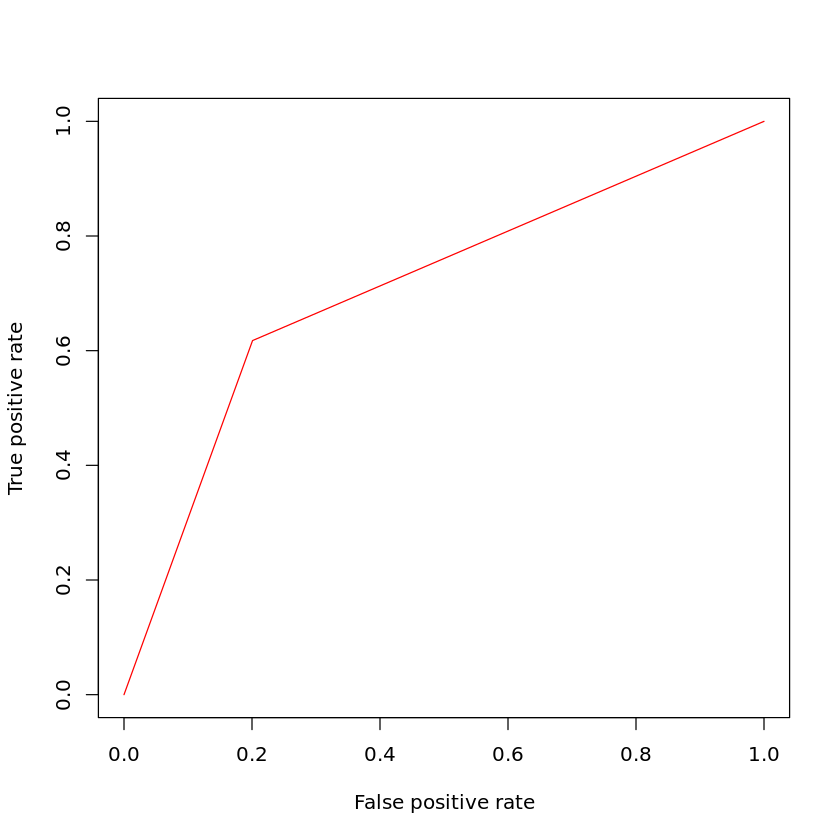

In [45]:
#Calculo las metricas
pred <- prediction(dtrain$Predicted, dtrain$clase)

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
plot(perf, col=rainbow(10))

#Determino AUC
performance( pred,"auc")@y.values


Cuanto dinero vale el modelo para el banco?

In [46]:
#Calculo la ganancia
sum( dtrain[ dtrain$Predicted==1, ganancia] )

[1] -14705000

In [47]:
#TP
sum(dtrain$Predicted*dtrain[,..kobjetivo])

[1] 525

In [48]:
#Incentivados Totales
sum(dtrain$Predicted)

[1] 32764

Corremos el modelo para el dataset del que no conocemos la clase

In [49]:
#Identifico casos a incentivar en el modelo definido
dapply[, TC_cactividad := Visa_cconsumos + Master_cconsumos ]
dapply[ , Predicted  := as.integer(TC_cactividad < 1) ]

#Inputo missings
dapply[is.na(dapply)] <- 0

#Grabo prediccion en salida
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= "./exp/EDA/1TRX.csv", 
        sep= "," )

Modelo alternativo con regla mas amplia. Incentivo todos aquellos que tienen menos de tres trx

[[1]]
[1] 0.7122607

[1] "La Ganancia es: -40491250"


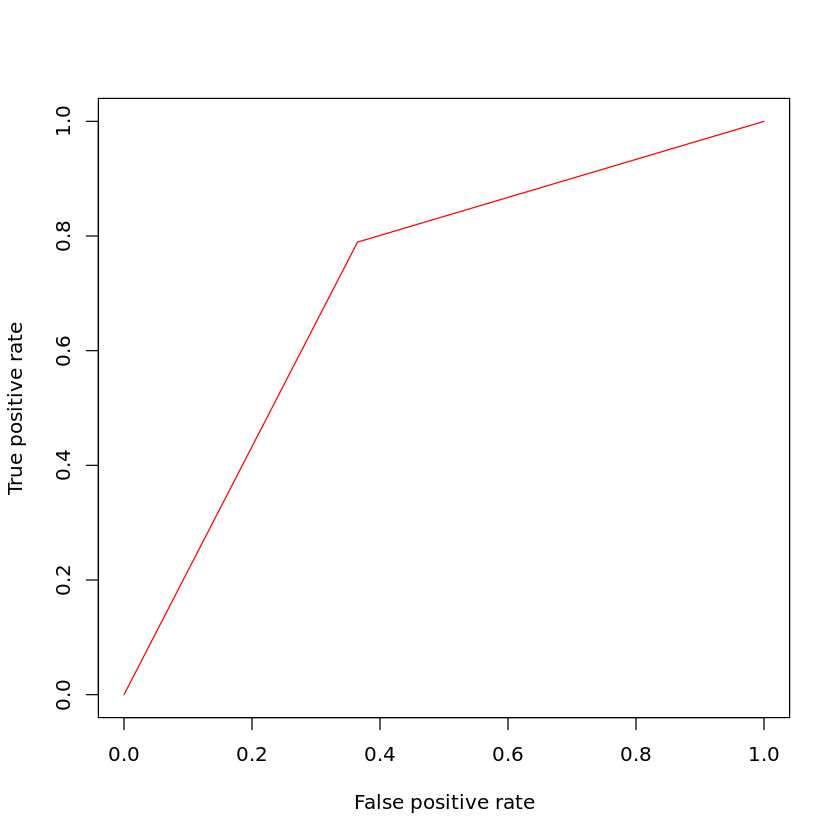

In [52]:
dtrain[ , Predicted  := as.integer(TC_cactividad < 3) ]
pred <- prediction(dtrain$Predicted, dtrain$clase)

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
plot(perf, col=rainbow(10))

#Determino AUC
performance( pred,"auc")@y.values

#Calculo la ganancia
print(paste("La Ganancia es:", sum( dtrain[ dtrain$Predicted==1, ganancia] )))

In [54]:
#Identifico casos a incentivar en el modelo definido
dapply[, TC_cactividad := Visa_cconsumos + Master_cconsumos ]
dapply[ , Predicted  := as.integer(TC_cactividad < 3) ]

#Grabo prediccion en salida
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= "./exp/EDA/3TRX.csv", 
        sep= "," )


Modelo alternativo con regla mas estricta. Incentivo todos aquellos que no tienen trx pero si en el trimestre

[[1]]
[1] 0.6183935

[1] "La Ganancia es: 7615000"


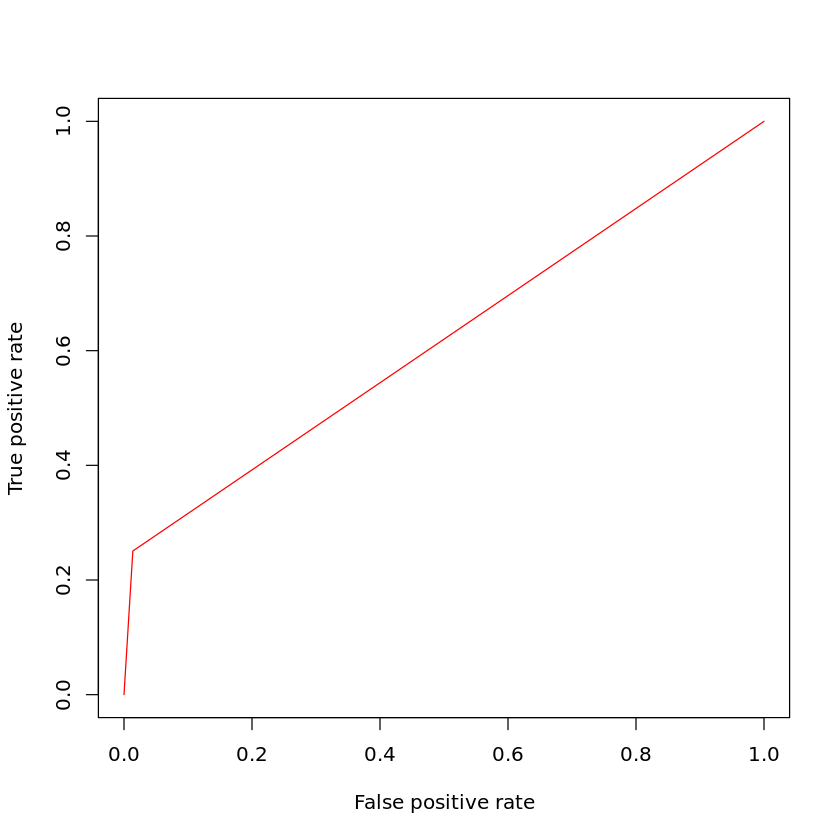

In [62]:
dtrain[ , Predicted  :=  as.integer((mcuentas_saldo < -1000)
                               & (ctrx_quarter < 10)
                              ) ]

pred <- prediction(dtrain$Predicted, dtrain$clase)

perf <- performance(pred, measure = "tpr", x.measure = "fpr")
plot(perf, col=rainbow(10))
performance( pred,"auc")@y.values

#Calculo la ganancia
print(paste("La Ganancia es:", sum( dtrain[ dtrain$Predicted==1, ganancia] )))

In [63]:
#Identifico casos a incentivar en el modelo definido
dapply[ , Predicted  :=  as.integer((mcuentas_saldo < -1000) 
                               & (ctrx_quarter < 10)
                              ) ]

#Grabo prediccion en salida
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= "./exp/EDA/Basico_restrictivo.csv", 
        sep= "," )


